In [2]:
#Import the necessary packages
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.datasets import make_classification
import warnings
from IPython.display import display
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

#feature pre-processing and principal component analysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Train-test-split
from sklearn.model_selection import train_test_split

# Classifiers ensembling
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

#Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

from time import time
from scipy.stats import ttest_ind

#Plotting
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format

from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Suppressing annoying harmless error
warnings.filterwarnings(
     action="ignore",
    module="scipy",
    message="^internal gelsd"
)
warnings.simplefilter('ignore')


In [3]:
!pip install mlxtend

In [6]:
!pip install imblearn

In [4]:
# Read the data 
safe_driver = pd.read_excel('C:\\Users\\CH40068799\\OneDrive - Wipro\\Documents\\Data Science\\ML projects files\\Project 7\\IT_3.xlsx')

In [5]:
#Check if the data has any negative values
safe_driver.where(safe_driver < 0).sum()

TypeError: '<' not supported between instances of 'str' and 'int'

In [6]:
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            30240 non-null  int64  
 1   target                        30240 non-null  int64  
 2   Gender                        30240 non-null  object 
 3   EngineHP                      30240 non-null  int64  
 4   credit_history                30240 non-null  int64  
 5   Years_Experience              30240 non-null  int64  
 6   annual_claims                 30240 non-null  int64  
 7   Marital_Status                30240 non-null  object 
 8   Vehical_type                  30240 non-null  object 
 9   Miles_driven_annually         30232 non-null  float64
 10  size_of_family                30240 non-null  int64  
 11  Age_bucket                    30240 non-null  object 
 12  EngineHP_bucket               30240 non-null  object 
 13  Y

In [7]:
safe_driver.describe()

,ID,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
count,30240.000,30240.000,30240.000,30240.000,30240.000,30240.000,30232.000,30240.000
mean,15120.500,0.708,196.604,685.770,13.256,1.138,17422.939,4.521
std,8729.680,0.455,132.347,102.454,9.890,1.083,17483.783,2.287
min,1.000,0.000,80.000,300.000,1.000,0.000,5000.000,1.000
25%,7560.750,0.000,111.000,668.000,5.000,0.000,9668.500,3.000
50%,15120.500,1.000,141.000,705.000,10.000,1.000,12280.000,5.000
75%,22680.250,1.000,238.000,753.000,20.000,2.000,14697.250,7.000
max,30240.000,1.000,1005.000,850.000,40.000,4.000,99943.000,8.000


In [8]:
from scipy import stats
x, _ = stats.boxcox(safe_driver['credit_history'])

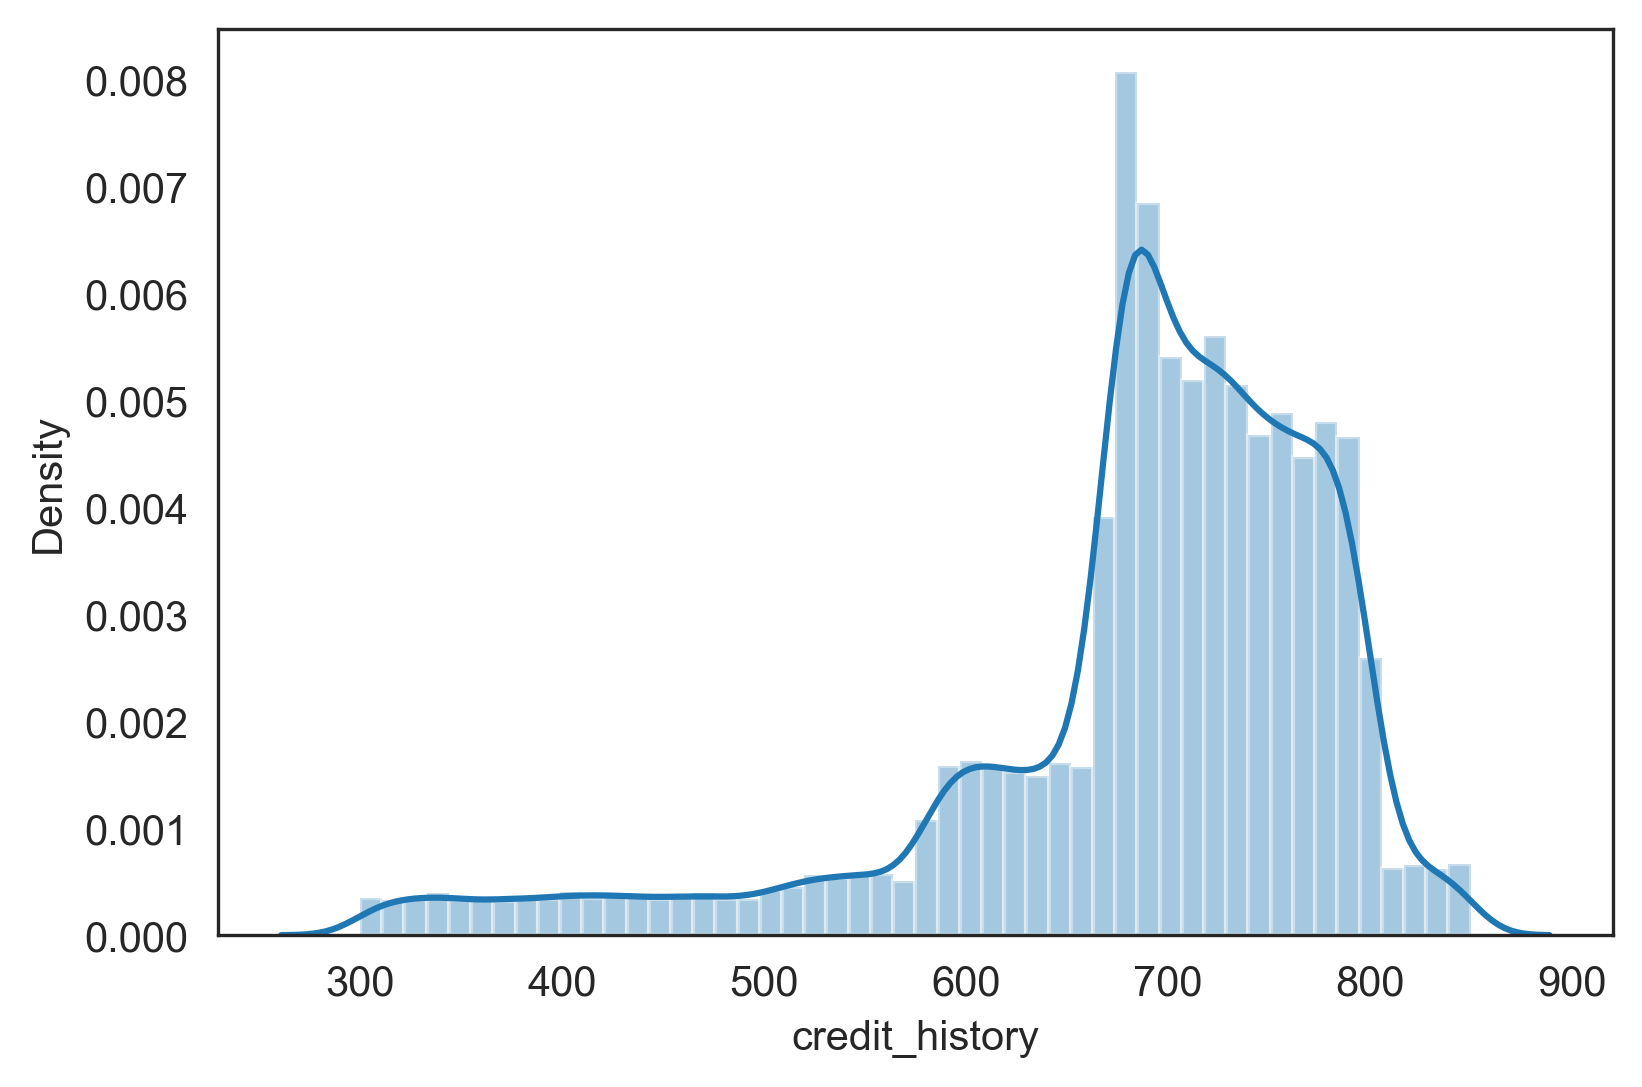

In [9]:
ax = sns.distplot(safe_driver.credit_history)

In [10]:
# Check and see if we have an imbalanced class label in the dataset
# Calculate the percentage of success data ('target'==1) w.r.t. the failure data ('target' ==0)
true_claims = (safe_driver['target'] == 1).sum()
print('True Claims is {}'.format(true_claims))

total_records = len(safe_driver['target'])
print('Total no. of records is {}'.format(total_records))
print('The percentage of true claims is {}%'.format(
       round(true_claims / total_records * 100), 2))

True Claims is 21396
Total no. of records is 30240
The percentage of true claims is 71%


In [12]:
cat_features = safe_driver.select_dtypes(include=['object']).copy()
cat_features.columns

Index(['Gender', 'Marital_Status', 'Vehical_type', 'Age_bucket',
       'EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket', 'State'],
      dtype='object')

Among the categorical variables we retain- Gender, Marital_status, Vehicle_type, Age_bucket.
EngineHP_bucket, Years_experience_bucket, Miles_driven_annually_bucket, credit_history_bucket have a corresponding continuous variable. Keeping Age_bucket as there is no continuous variable.

In [13]:
# Dropping 5 columns: ID, EngineHP_bucket, Years_experience_bucket, Miles_driven_annually_bucket, credit_history_bucket 
safe_driver.drop(['ID','EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket'], axis=1, inplace=True)

In [14]:
# Checking if the dataset has any null values
safe_driver.isnull().sum()

target                   0
Gender                   0
EngineHP                 0
credit_history           0
Years_Experience         0
annual_claims            0
Marital_Status           0
Vehical_type             0
Miles_driven_annually    8
size_of_family           0
Age_bucket               0
State                    0
dtype: int64

In [15]:
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,State
1235,1,F,124,793,27,0,Married,Truck,NaN,3,>40,NJ
7365,0,F,465,696,5,0,Married,Truck,NaN,8,18-27,SD
11464,1,F,137,787,18,1,Married,Truck,NaN,1,>40,CT
18158,0,F,108,747,8,1,Married,Truck,NaN,1,18-27,OR
19795,1,F,121,774,19,0,Married,Truck,NaN,2,28-34,NY
25731,1,F,355,694,15,1,Married,Truck,NaN,5,28-34,CT
26512,1,F,109,743,40,0,Married,Truck,NaN,1,>40,OR
27045,1,F,83,784,21,0,Married,Truck,NaN,1,>40,CT


In [17]:
median_values = safe_driver.groupby('Vehicle_type').median()
median_values

KeyError: 'Vehicle_type'